In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.signal_list)))
# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [4]:
dout = "gen_studies/genjets/"

In [5]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [7]:
def make_genjet_variables(tree):
    genjets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_genjet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    
    recojets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_recojet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    
    genjet_genjet_dr = calc_dr(
        genjets.eta[:, :, None], genjets.phi[:, :, None], genjets.eta[:, None], genjets.phi[:, None])
    min_genjet_dr = ak.min(genjet_genjet_dr[genjet_genjet_dr!=0],axis=-1)
    
    genjet_recojet_dr = calc_dr(
        genjets.eta[:, :, None], genjets.phi[:, :, None], recojets.eta[:, None], recojets.phi[:, None])
    min_recojet_dr = ak.min(genjet_recojet_dr,axis=-1)
    
    quark_matched = 1*(genjets.pt>0)
    recojet_matched = 1*(recojets.pt>0)
    
    tree.extend(
        **{
            f'gen_{quark}_id': i*ak.ones_like(tree.Run)
            for i, quark in enumerate(eightb.quarklist)
        },
        **{
            f'{quark}_genjet_quark_matched': quark_matched[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'{quark}_genjet_min_genjet_dr': min_genjet_dr[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'{quark}_genjet_recojet_matched': recojet_matched[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'{quark}_genjet_min_recojet_dr': min_recojet_dr[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'n_unmatched_genjet':ak.sum( (recojet_matched==0)[quark_matched==1],axis=-1),
            f'n_unmatched_genjet_dr4':ak.sum(((recojet_matched==0)&(min_recojet_dr>0.4))[quark_matched==1],axis=-1),
        }
    )

In [8]:
signal_trees.apply(make_genjet_variables)

[None, None, None]

In [9]:
signal_trees.apply(lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark',ordered="genjet_pt"))


[None, None, None]

In [10]:
def frac_unmatched_genjet(t):
    gen_matched = t.gen_quark_genjet_quark_matched
    reco_matched = t.gen_quark_genjet_recojet_matched

    gen_not_reco = (gen_matched == 1) & (reco_matched == 0)
    n_gen_not_reco = ak.sum(gen_not_reco, axis=-1)
    t.extend(n_gen_not_reco=n_gen_not_reco)
    return ak.mean(n_gen_not_reco>0,axis=-1)

signal_trees.apply(frac_unmatched_genjet)

[0.25104815287775883, 0.21267119955896183, 0.18621285123438366]

100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


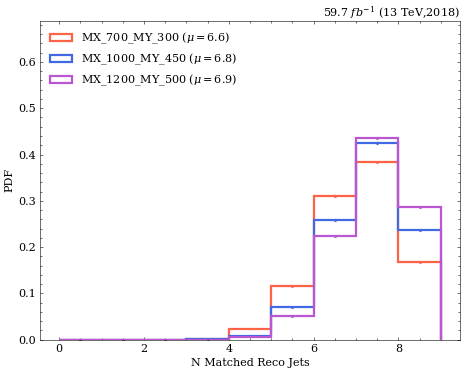

In [11]:
study.quick(
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['nfound_all'],
    xlabels=['N Matched Reco Jets'],
    efficiency=True,
    saveas=f'{dout}/n_matched_reco_jets'
)

100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


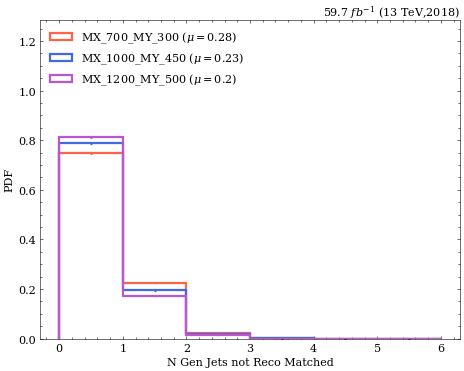

In [14]:
study.quick(
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['n_gen_not_reco'],
    xlabels=['N Gen Jets not Reco Matched'],
    efficiency=True,
    saveas=f'{dout}/n_gen_unmatched_reco_jets'
)

In [ ]:
study.quick(
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=[],
    xlabels=['N Matched Reco Jets'],
    efficiency=True,
    saveas=f'{dout}/n_matched_reco_jets'
)

100%|██████████| 4/4 [00:00<00:00, 14.07it/s]


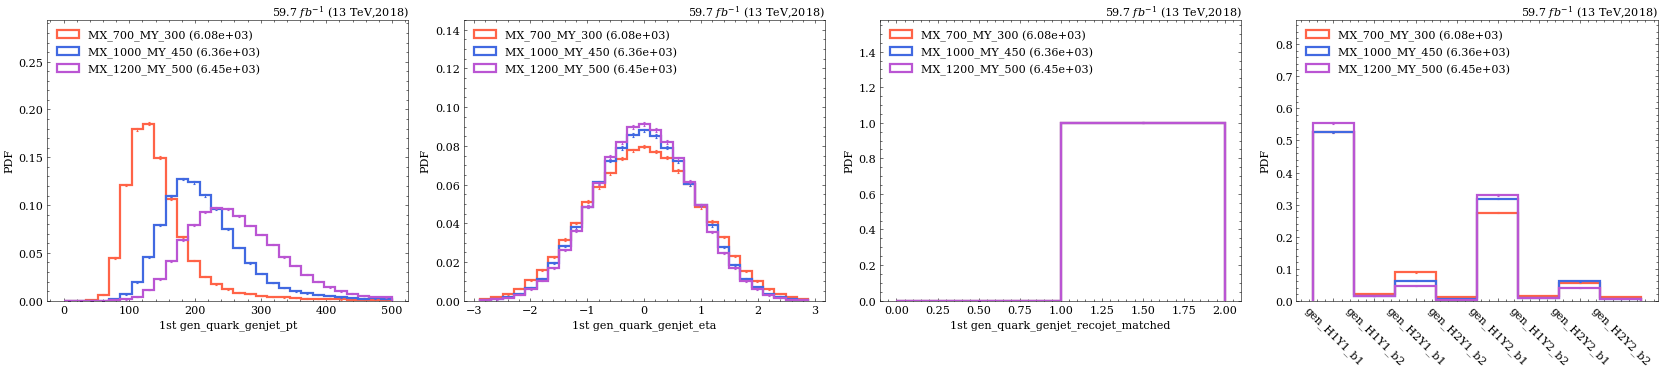

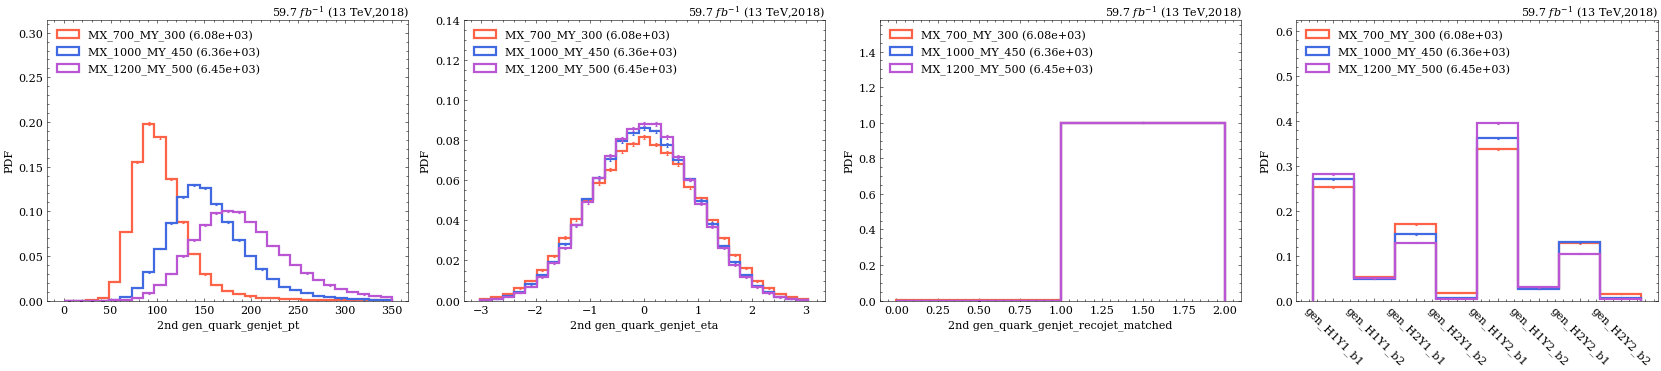

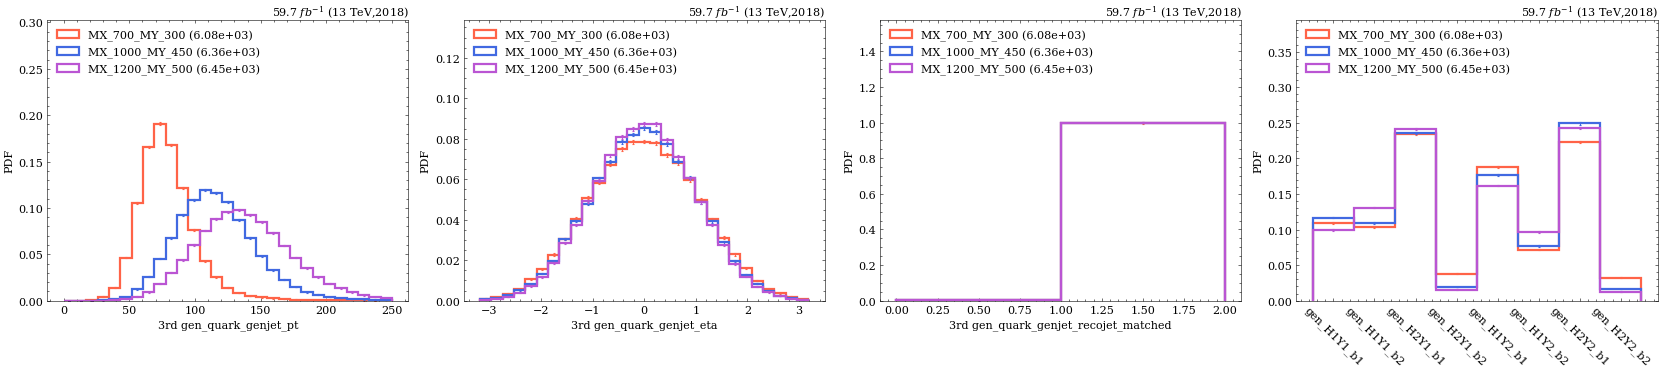

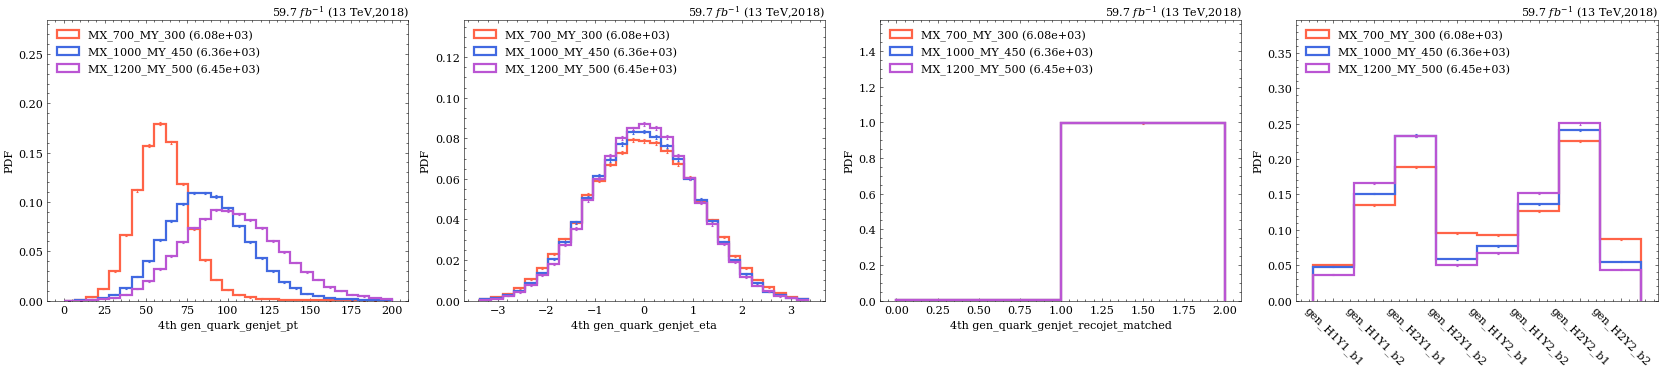

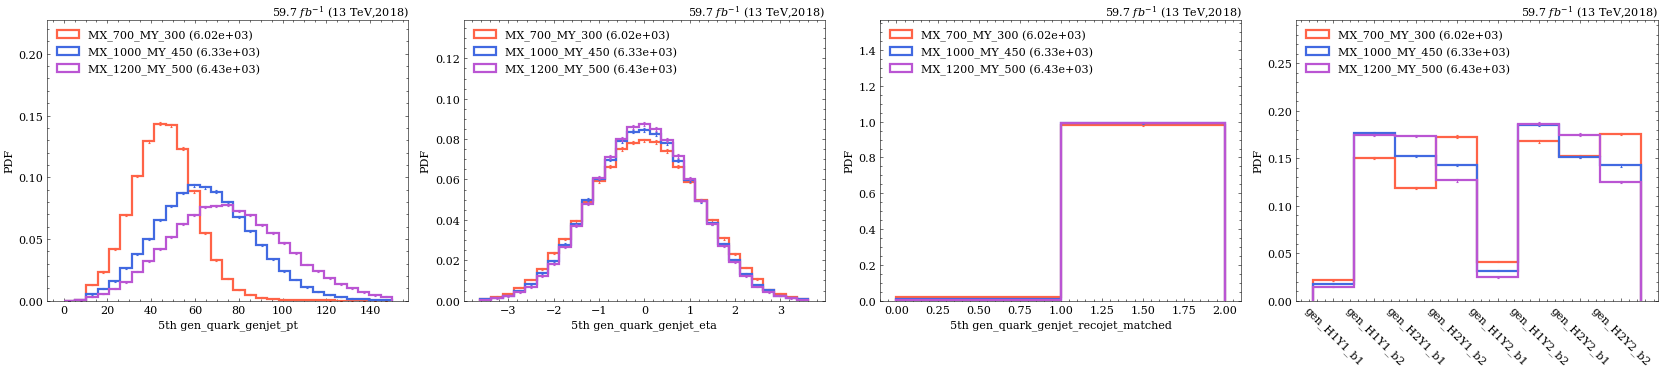

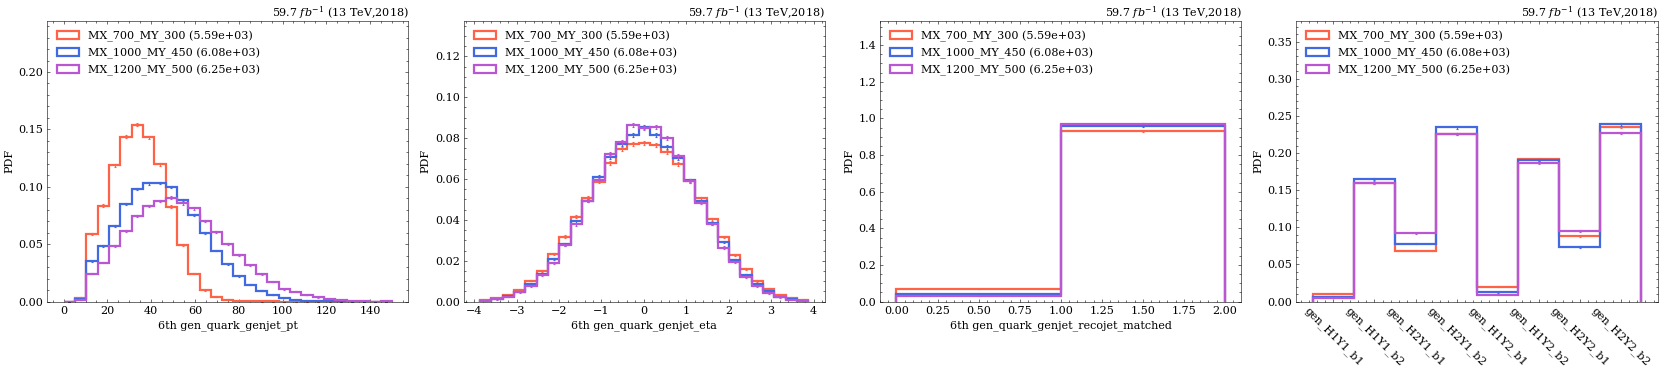

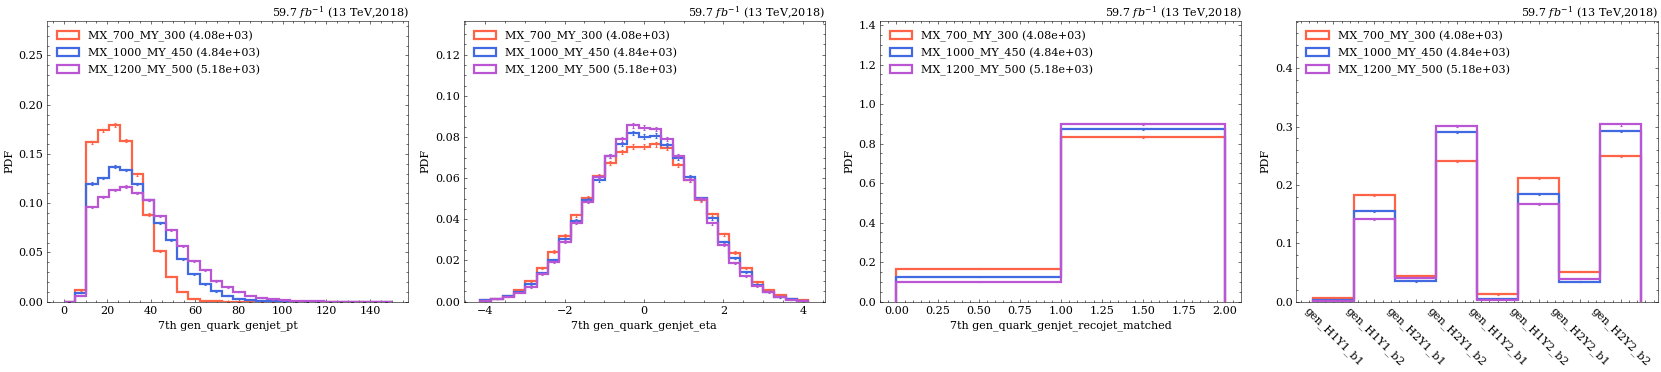

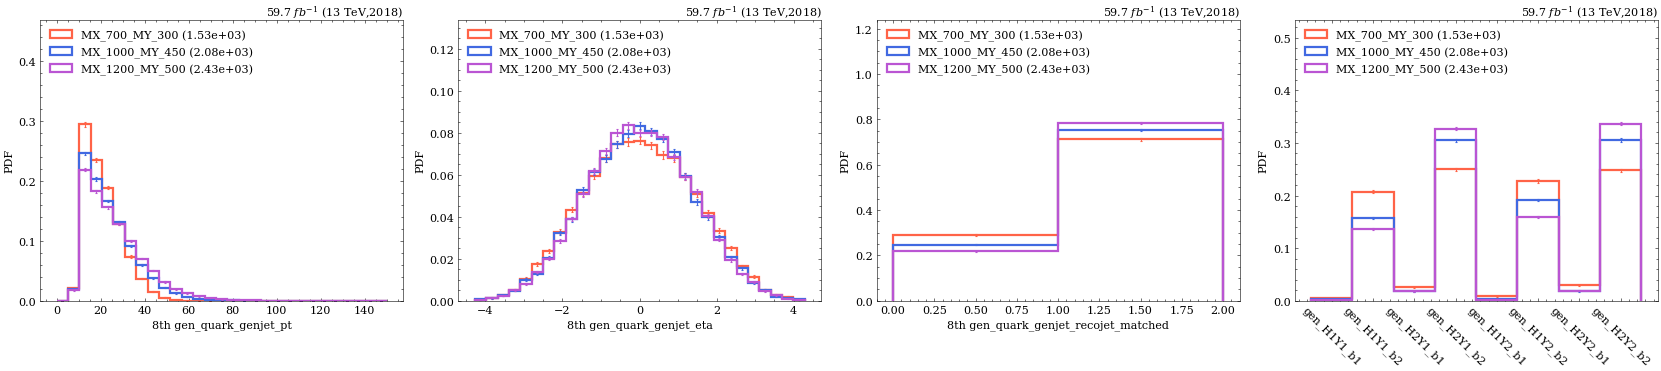

In [26]:
varlist = ['genjet_pt','genjet_eta','genjet_recojet_matched','id']

varinfo.gen_quark_id = dict(xlabel=[f"gen_{quark}" for quark in eightb.quarklist], bins=np.arange(9))

ptmax_ = [500,350,250,200,150,150,150,150]

for i,quark in enumerate(quarklist):
    ptmax = ptmax_[i]
    study.quick(
        signal_trees, legend=True,
        masks=lambda t : t.gen_quark_genjet_pt[:,i]>0,
        varlist=[f'gen_quark_{var}[:,{i}]' for var in varlist],
        efficiency=True,
        binlist=[(0,ptmax,30)],
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_gen_jet'
    )

In [23]:
def genjet_res(t):
    varlist = ['pt','eta','phi']
    resolution = {
        f'gen_quark_genjet_{var}_res': t[f'gen_quark_genjet_{var}']/t[f'gen_quark_{var}']
        for var in varlist
    }
    t.extend(**resolution)

signal_trees.apply(genjet_res)

[None, None, None]

100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


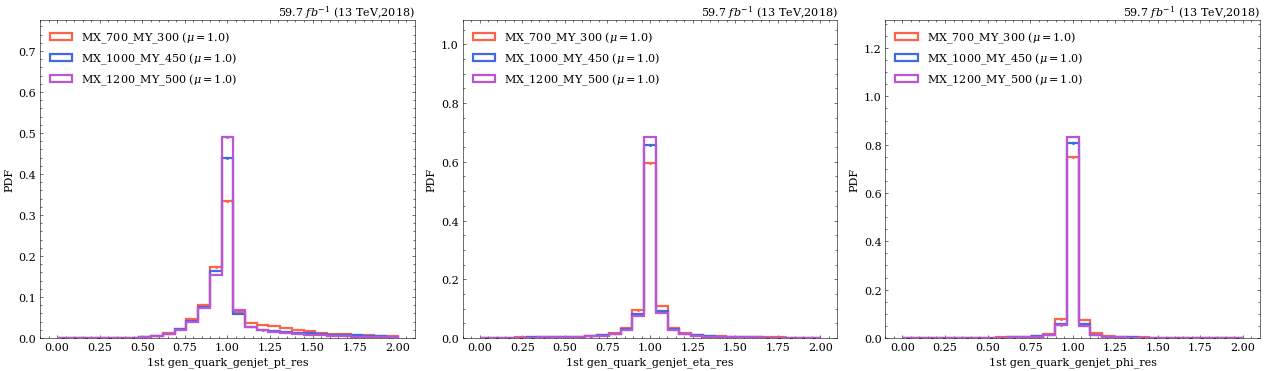

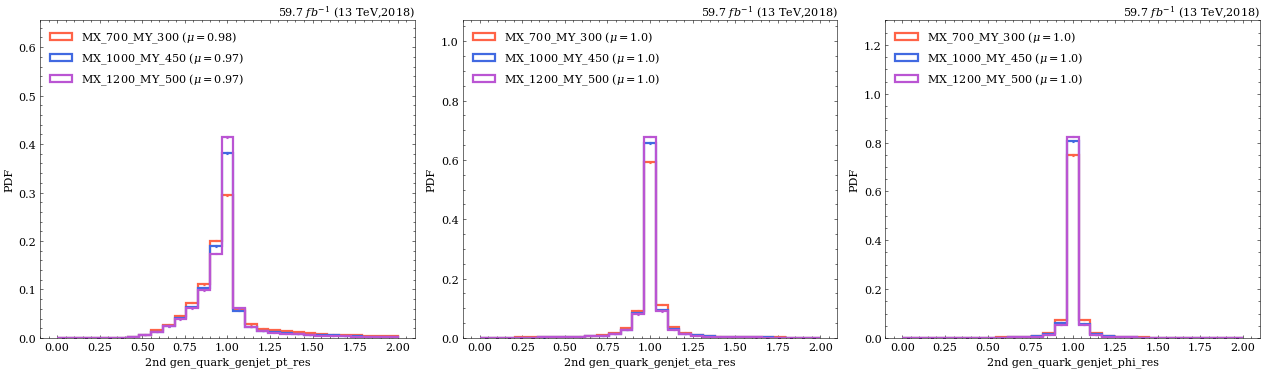

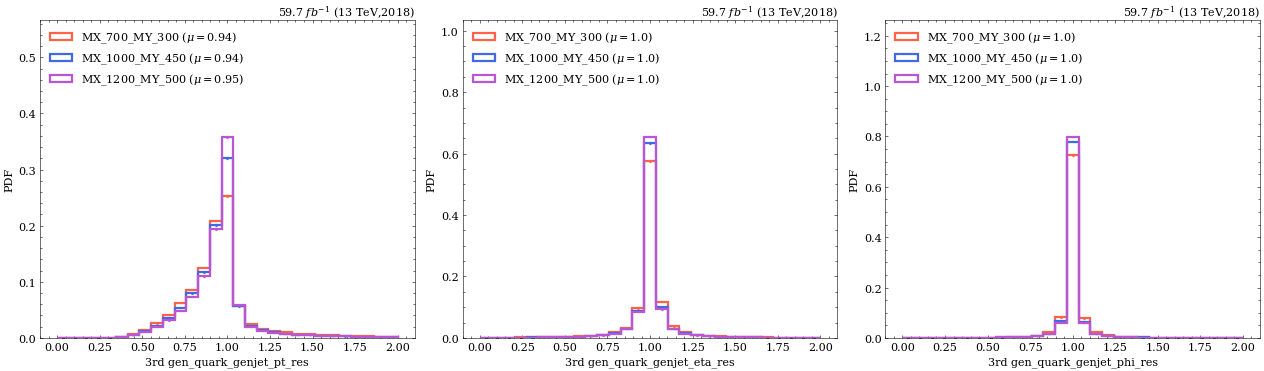

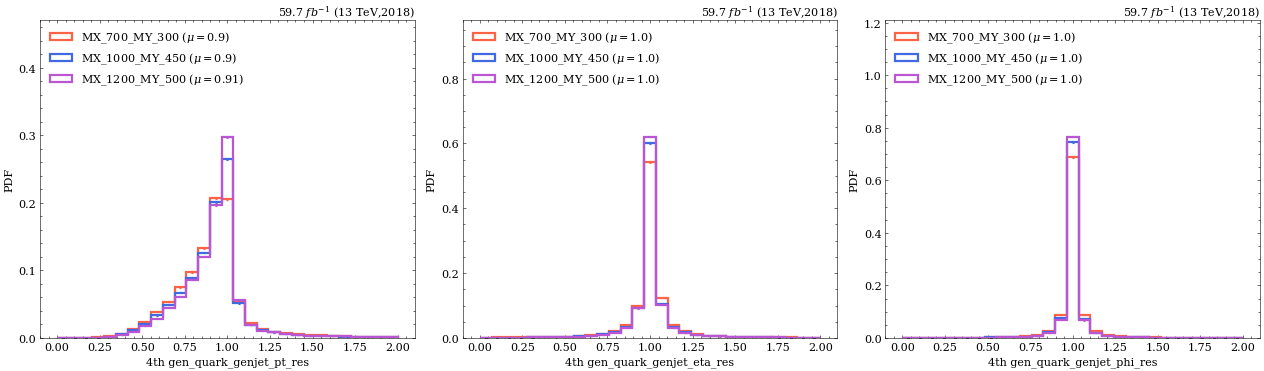

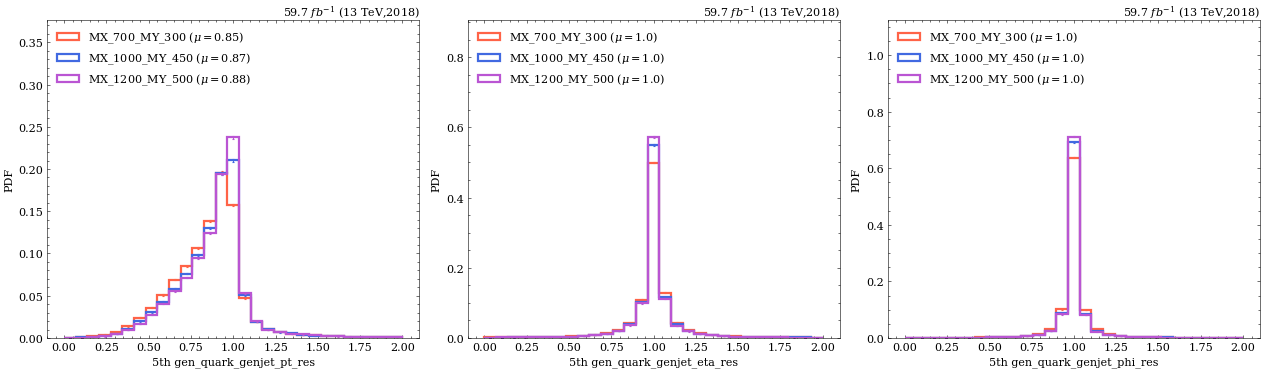

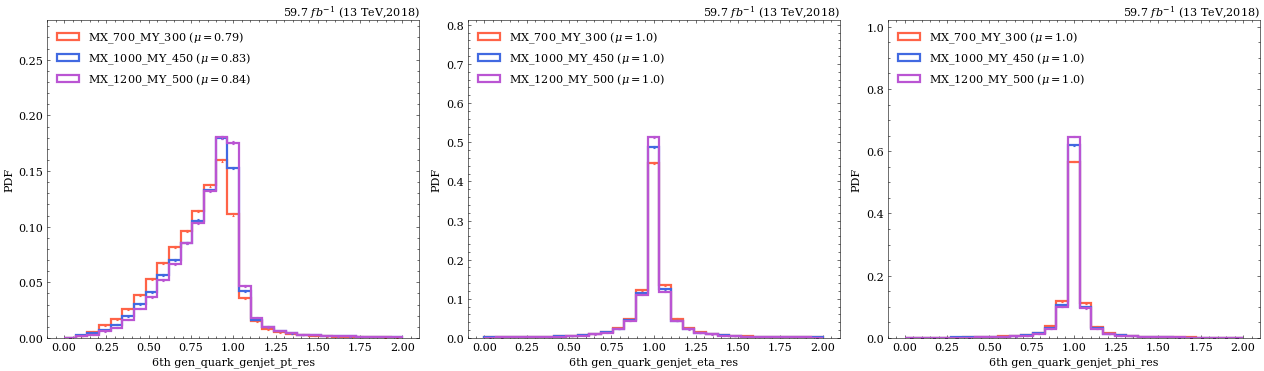

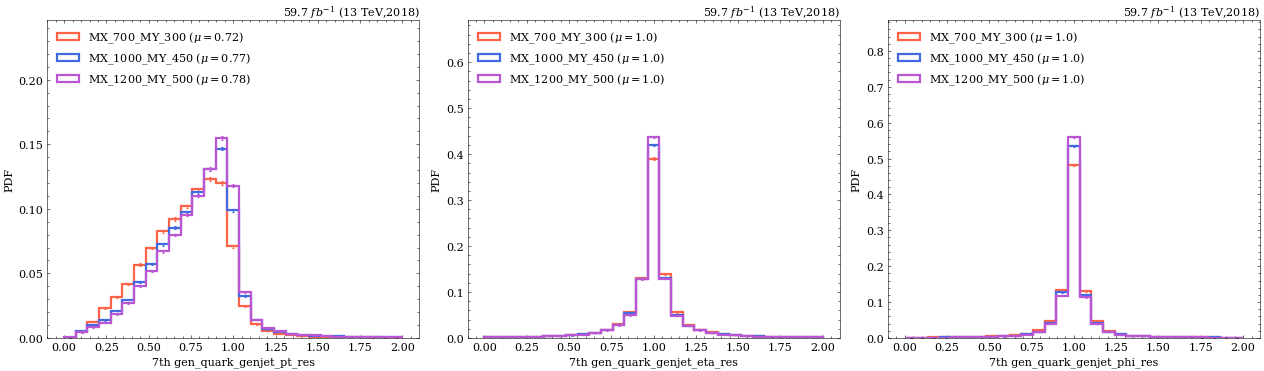

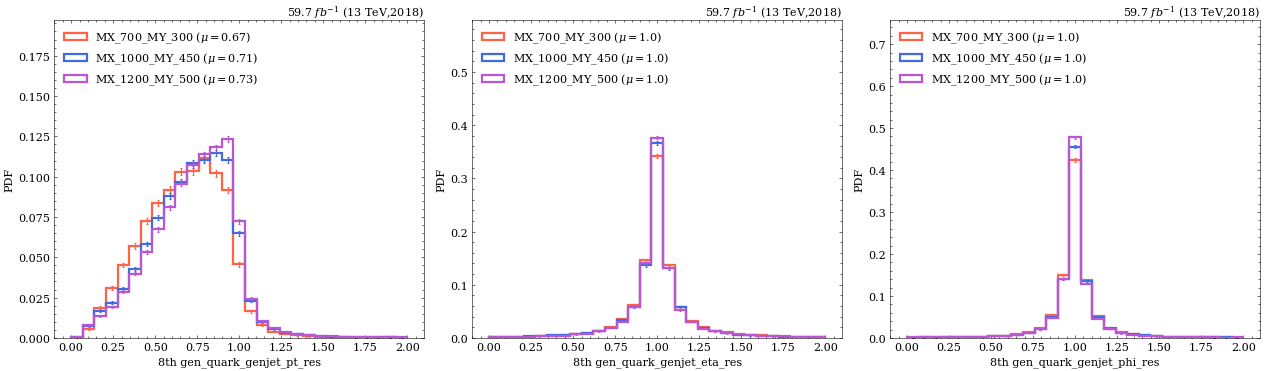

In [27]:
varlist = ['pt','eta','phi']

for i,quark in enumerate(quarklist):
    study.quick(
        signal_trees, legend=True, h_label_stat='mean',
        masks=lambda t : t.gen_quark_genjet_pt[:,i]>0,
        varlist=[f'gen_quark_genjet_{var}_res[:,{i}]' for var in varlist],
        binlist=[(0,2,30)]*len(varlist),
        efficiency=True,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_gen_jet_res'
    )

100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


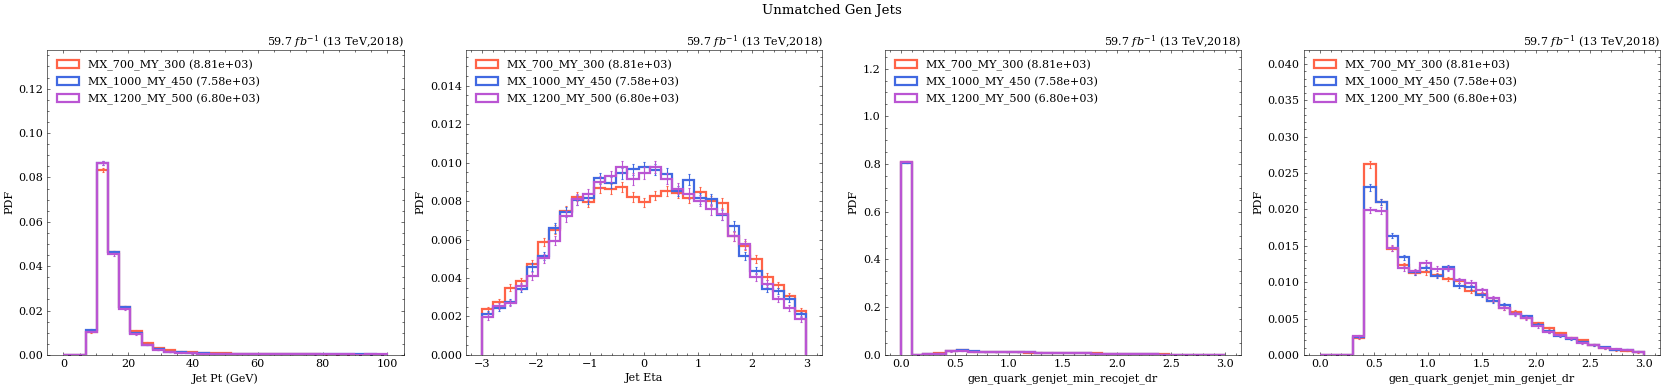

In [30]:
varlist=['genjet_pt','genjet_eta','genjet_min_recojet_dr','genjet_min_genjet_dr']
study.quick(
    signal_trees, legend=True, 
    indices=lambda t:t.gen_quark_genjet_recojet_matched==0,
    suptitle='Unmatched Gen Jets',
    varlist=[f'gen_quark_{var}' for var in varlist],
    binlist=[(0,100,30),None,(0,3,30),(0,3,30)],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/unmatched_genjets'
)